In [1]:
%load_ext lab_black
import datasets

nyctracts = datasets.GetNYCCensusTracts()

In [2]:
from cartoframes.viz import Map
from cartoframes.viz.helpers import color_category_layer

nyctracts.data["county_fips"] = nyctracts.data.geoid.str[:5]

Map(color_category_layer(nyctracts.data, "county_fips", title="County FIPS"))

In [3]:
import time as time
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

X = nyctracts.data_points[["latitude", "longitude"]].values

# Compute clustering
ward = AgglomerativeClustering(n_clusters=10).fit(X)

nyctracts.data_points["label_unstructured"] = [str(l) for l in ward.labels_]

Map(color_category_layer(nyctracts.data_points, "label_unstructured"))

The previous method uses the distances calculated in lat/long space for the linkage 

In [4]:
# Compute structured clustering
from libpysal.weights import Rook

wgt = Rook.from_dataframe(nyctracts.data, idVariable="cartodb_id")
X = nyctracts.data_points[["latitude", "longitude"]].values

/Users/aeschbacher/.local/share/virtualenvs/region-KL9g70pJ/lib/python3.7/site-packages/libpysal/weights/weights.py:165: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


In [5]:
ward = AgglomerativeClustering(n_clusters=10, connectivity=wgt.sparse).fit(X)

nyctracts.data_points["label_structured_islands"] = list(str(l) for l in ward.labels_)

/Users/aeschbacher/.local/share/virtualenvs/region-KL9g70pJ/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning: the number of connected components of the connectivity matrix is 6 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


In [6]:
Map(color_category_layer(nyctracts.data_points, "label_structured_islands", top=16))

If there are disjoint areas, like above where there are six disconnected regions, then the [connectivity graph is 'completed'](https://stackoverflow.com/questions/42821622/scikit-learn-agglomerative-clustering-connectivity-matrix) by the Agglomerative clustering algorithm implemented in scikit-learn to add additional linkage to create a single graph.

/Users/aeschbacher/.local/share/virtualenvs/region-KL9g70pJ/lib/python3.7/site-packages/libpysal/weights/weights.py:165: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


(<Figure size 1296x1728 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b214690>)

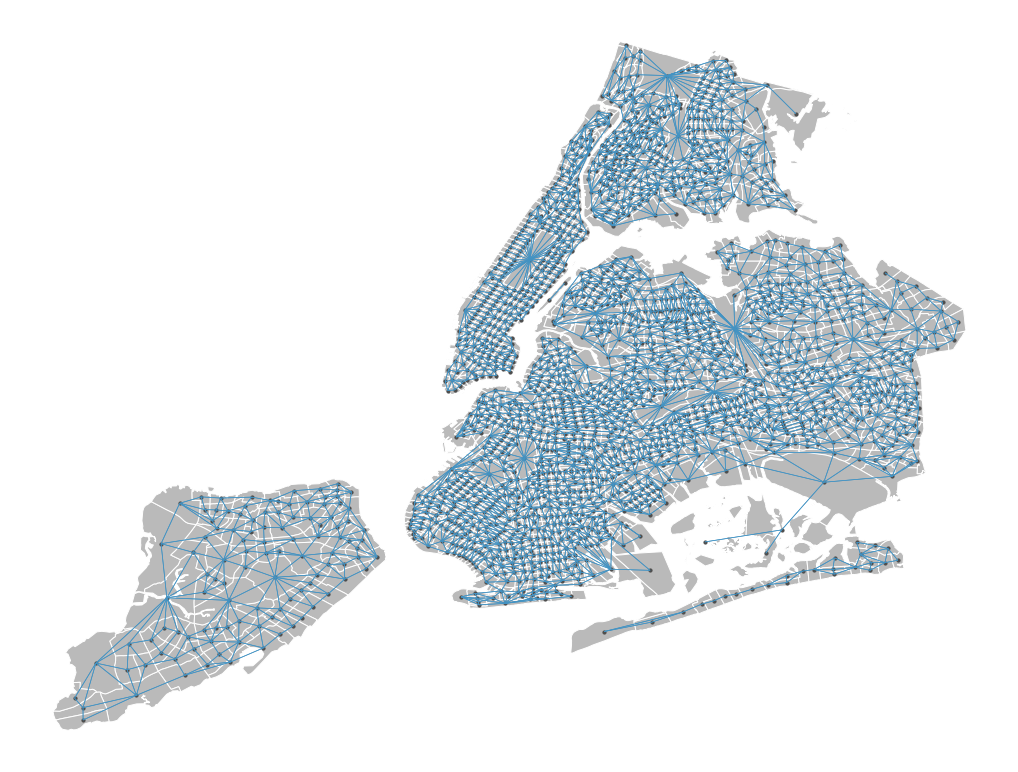

In [7]:
from splot.libpysal import plot_spatial_weights
import matplotlib.pyplot as plt

wgt = Rook.from_dataframe(nyctracts.data)

fig, ax = plt.subplots(1, 1, figsize=(18, 24))

plot_spatial_weights(wgt, nyctracts.data, ax=ax)

In [8]:
# manually-created connections on bridges
bridge_connections = {
    # Verrazzano-Narrows Bridge (Staten Island <-> Brooklyn)
    4551: [2571],
    2571: [4551],
    # Williamsburg Bridge (Manhattan <-> Brooklyn)
    2923: [3498],
    3498: [2923],
    # Queensborough Bridge (Manhattan <-> Queens)
    3595: [3900],
    3900: [3736, 3595],
    # Roosevelt Island <-> Queens
    3736: [3900],
    # Astoria <-> East Harlem
    3943: [3688],
    3688: [2028, 3943],
    # East Harlem <-> Bronx
    2028: [3688],
    # Northern Manhattan <-> Marble Hill
    3769: [2237],
    2237: [3769],
    # Rockaways
    4411: [3009],
    3009: [4411],
}

index_rownum_mapping = {idx: ridx for ridx, idx in enumerate(nyctracts.data.index)}
mapped_connections = dict.fromkeys(
    [index_rownum_mapping[idx] for idx in bridge_connections], []
)

for k in bridge_connections:
    mapped_connections[index_rownum_mapping[k]] = [
        index_rownum_mapping[v] for v in bridge_connections[k]
    ]

In [9]:
import warnings
from libpysal.weights import w_union, W

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wgt = Rook.from_dataframe(nyctracts.data)
    mapped_weights = W(mapped_connections)

wgt_unioned = w_union(wgt, mapped_weights)

(<Figure size 1296x1728 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12a0db450>)

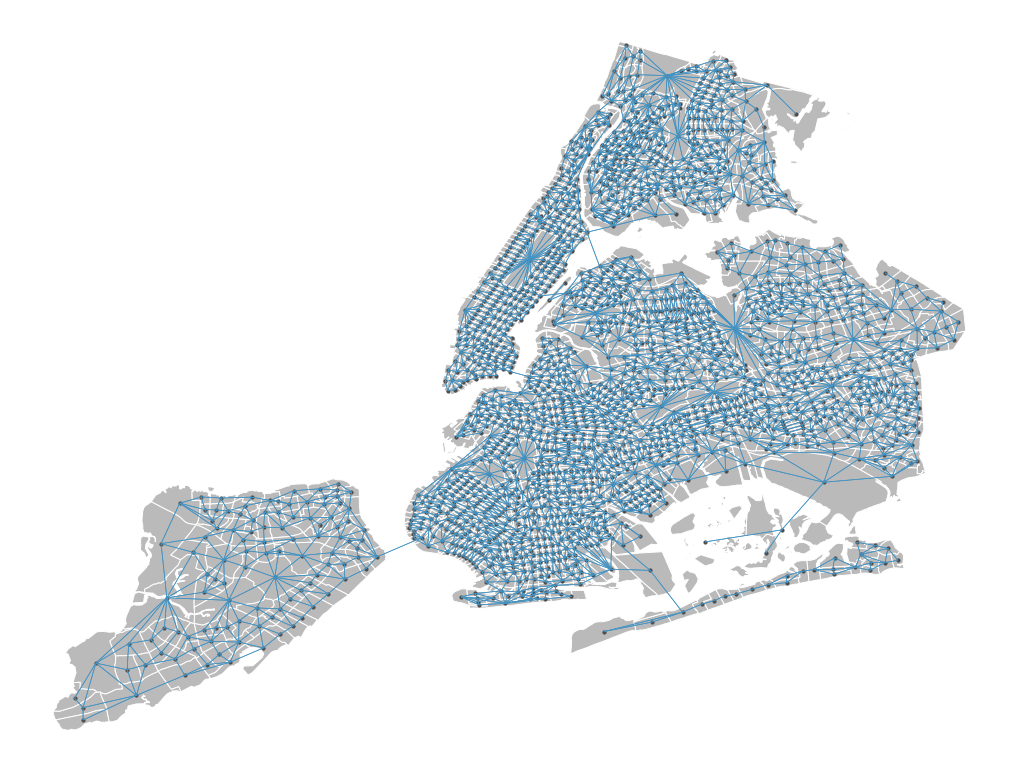

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(18, 24))

plot_spatial_weights(wgt_unioned, nyctracts.data, ax=ax)

In [11]:
from networkx.algorithms import components

nx_graph = wgt_unioned.to_networkx()
components.number_connected_components(nx_graph)

1

In [13]:
X = nyctracts.data_points[["latitude", "longitude"]].values

ward = AgglomerativeClustering(
    n_clusters=13, connectivity=wgt_unioned.sparse, linkage="ward"
).fit(X)
label = ward.labels_
nyctracts.data["label_structured_connected"] = [str(l) for l in label]

Map(
    color_category_layer(
        nyctracts.data,
        "label_structured_connected",
        top=16,
        title="Agglomerative Clustering Labels",
    )
)